In [ ]:
# -*- coding: utf-8 -*-
"""
Full script for large-scale, iterative training and performance evaluation of detectors.

V3 - 4D DATASET VERSION
This version adapts the script to handle HDF5 datasets with a 4D shape of
(trials, windows, frequencies, features). It includes a new rolling average
function and updated data loaders to correctly process the temporal 'windows' dimension.
"""

# %% 1. Imports and Configuration
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from tqdm import tqdm
import math

# Ignore specific warnings to keep output clean
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning, message="Starting from version 2.2.1")

# ##############################################################################
# SECTION 1: USER-DEFINED PARAMETERS & CONFIGURATION
# ##############################################################################

# --- Experiment Control Parameters ---
TRAINING_SAMPLE_STOPS = [1000, 10000, 15000]
EVAL_TRIAL_STOPS = [5000]

# --- Model Training Parameters ---
MODELS_TO_TRAIN_AND_EVAL = ['PPO-Rolling-Avg-W18', 'LGBM', 'MSC', 'TFG']
ROLLING_WINDOW_SIZE = 18 # Note: This is now conceptual, as the new function does a full cumulative average.
RL_TRAINING_EPOCHS = 10
LGBM_N_ESTIMATORS = 100
NEGATIVE_REWARD = -5.0

# --- Data and Path Configuration ---
HDF5_TRAIN_FILEPATH = '../data/train_v4.hdf5'
HDF5_EVAL_FILEPATH = '../data/train_v4.hdf5'

# --- Signal and Feature Configuration ---
NUM_SIGNAL_FREQS = 8
ALL_SNRS = [-30.0, -27.5, -25.0, -22.5, -20.0, -17.5, -15.0, -12.5, -10.0, -7.5, -5.0]
RAW_FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
MAX_EVAL_TRIALS_PER_SNR = max(EVAL_TRIAL_STOPS)

print(f"Training stops (samples): {TRAINING_SAMPLE_STOPS}")
print(f"Evaluation stops (trials/SNR): {EVAL_TRIAL_STOPS}")
print(f"Models to evaluate: {MODELS_TO_TRAIN_AND_EVAL}")


# ##############################################################################
# SECTION 2: DATA LOADING AND PREPARATION FUNCTIONS
# ##############################################################################

# NEW: This function correctly handles the 4D data (trials, windows, freqs, feats)
# by calculating the average over the 'windows' (time) dimension.
def create_rolling_avg_features_4d(data_4d):
    """
    Creates rolling average features over the 'windows' dimension of a 4D array.
    Shape: (trials, windows, freqs, features) -> (trials, windows, freqs, features)
    """
    # Calculate the cumulative sum along the 'windows' axis (axis=1)
    cumulative_sum = np.cumsum(data_4d, axis=1)
    
    # Create an array of window counts to divide by: [1, 2, 3, ...]
    num_windows = data_4d.shape[1]
    window_divisors = np.arange(1, num_windows + 1).reshape(1, -1, 1, 1)
    
    # Element-wise division to get the cumulative mean
    return cumulative_sum / window_divisors

# CHANGED: Replaces the old memory-intensive loader with a corrected version for 4D data.
def load_training_data_for_stage(filepath, snr_levels, total_samples_needed, num_signal_freqs):
    """
    Loads and prepares a specific number of training samples from 4D HDF5 data
    in a memory-efficient way.
    """
    X_all_snrs_4d = []
    
    # Determine how many trials to load to meet the total sample requirement.
    # A "sample" is one (frequency, window) pair.
    with h5py.File(filepath, 'r') as f:
        first_key = f"snr_{snr_levels[0]:.1f}"
        if first_key not in f:
             raise ValueError(f"Initial SNR key {first_key} not found in HDF5 file.")
        _, windows_per_trial, freqs_per_trial, _ = f[first_key]['metrics'].shape
        samples_per_trial = windows_per_trial * freqs_per_trial

    samples_per_snr = math.ceil(total_samples_needed / len(snr_levels))
    trials_per_snr = math.ceil(samples_per_snr / samples_per_trial)
    
    print(f"Loading up to {trials_per_snr} trials per SNR to gather enough samples.")
    
    with h5py.File(filepath, 'r') as f:
        for snr in snr_levels:
            key = f"snr_{snr:.1f}"
            if key in f:
                # Load the 4D data directly without transposing
                # Shape: (trials, windows, frequencies, features)
                metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]
                X_all_snrs_4d.append(metrics_data_4d)
            else:
                print(f"Warning: Training SNR {snr} not found in {filepath}")

    if not X_all_snrs_4d:
        return None

    # Combine data from all SNRs into a single 4D array
    X_full_4d = np.vstack(X_all_snrs_4d)
    
    num_trials, num_windows, num_freqs, num_features = X_full_4d.shape

    # --- Create Labels ---
    # Labels are based on frequency index, independent of trial or window
    freq_labels = np.zeros(num_freqs)
    freq_labels[:num_signal_freqs] = 1
    # Tile these labels to match the full data shape
    y_labels_4d = np.tile(freq_labels, (num_trials, num_windows, 1))

    # --- Flatten data for processing ---
    # Reshape to (total_samples, num_features)
    X_flat = X_full_4d.reshape(-1, num_features)
    y_flat = y_labels_4d.flatten()

    # --- Shuffle all samples together ---
    p = np.random.permutation(len(X_flat))
    X_flat_shuffled = X_flat[p]
    y_flat_shuffled = y_flat[p]
    
    # Slice to the EXACT number of samples needed
    samples_to_take = min(total_samples_needed, len(X_flat_shuffled))
    X_train_flat = X_flat_shuffled[:samples_to_take]
    y_train_flat = y_flat_shuffled[:samples_to_take]
    
    # --- Create Rolling Average Features ---
    # This must be done on the 4D data BEFORE shuffling and flattening
    print("Calculating rolling average features...")
    X_rolling_4d = create_rolling_avg_features_4d(X_full_4d)
    X_rolling_flat = X_rolling_4d.reshape(-1, num_features)
    # Use the same permutation and slice
    X_train_rolling = X_rolling_flat[p][:samples_to_take]
    # y_train_rolling = y_flat_shuffled[:samples_to_take] # Labels are the same

    return {
        'flat': (X_train_flat, y_train_flat),
        'rolling_avg': (X_train_rolling, y_train_flat) # Use the same y_train_flat
    }

# CHANGED: Simplified to load and split the 4D data correctly.
def load_evaluation_data_for_snr(filepath, snr, trials_per_snr, num_signal_freqs):
    """
    Loads 4D evaluation data for a single SNR and splits it into signal and noise.
    Returns two 4D arrays.
    """
    try:
        with h5py.File(filepath, 'r') as f:
            key = f"snr_{snr:.1f}"
            if key not in f:
                return np.array([]), np.array([])
            
            # Load the 4D data directly. Shape: (trials, windows, freqs, features)
            metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]

        # Split along the frequency axis (axis=2)
        signal_data_4d = metrics_data_4d[:, :, :num_signal_freqs, :]
        noise_data_4d = metrics_data_4d[:, :, num_signal_freqs:, :]
        
        return signal_data_4d, noise_data_4d
    except Exception as e:
        print(f"Error loading evaluation data for SNR {snr}: {e}")
        return np.array([]), np.array([])


# ##############################################################################
# SECTION 3: MODELS, ENVIRONMENT, AND HELPER FUNCTIONS (Unchanged)
# ##############################################################################

class SignalDetectionEnv(gym.Env):
    def __init__(self, features, labels, negative_reward=-1.0):
        super().__init__()
        self.features, self.labels = features, labels
        self.negative_reward = negative_reward
        self.current_step = 0
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)
    def step(self, action):
        predicted_label = 1 if action[0] > 0 else 0
        reward = 1.0 if predicted_label == self.labels[self.current_step] else self.negative_reward
        self.current_step += 1
        terminated = self.current_step >= len(self.features)
        next_obs = self.features[self.current_step] if not terminated else np.zeros(self.observation_space.shape)
        return next_obs, reward, terminated, False, {}
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return self.features[0], {}

class ORDTester:
    def __init__(self, desired_alpha=0.05, feature_names=RAW_FEATURE_NAMES):
        self.desired_alpha = desired_alpha
        self.feature_names = feature_names
        self.thresholds = {}
    def train(self, noise_features):
        for i, key in enumerate(self.feature_names):
            if noise_features.shape[0] > 0:
                self.thresholds[key] = np.percentile(noise_features[:, i], (1 - self.desired_alpha) * 100)
    def predict(self, features):
        decisions = {}
        for i, name in enumerate(self.feature_names):
            if name in self.thresholds:
                decisions[name] = (features[:, i] > self.thresholds[name]).astype(int)
            else:
                decisions[name] = np.zeros(features.shape[0], dtype=int)
        return decisions

def predict_lgbm(model, features_flat): return model.predict(features_flat)

def predict_ppo(model, features_flat):
    preds, _ = model.predict(features_flat, deterministic=True)
    preds[np.isnan(preds)] = 0
    return (preds > 0).astype(int)

def predict_statistical(model, features_flat, detector_name):
    decisions = model.predict(features_flat)
    return decisions.get(detector_name, np.zeros(features_flat.shape[0], dtype=int))

def calculate_statistics(predictions_per_trial):
    per_trial_metric = np.mean(predictions_per_trial, axis=1)
    return {
        'mean': np.mean(per_trial_metric),
        'variance': np.var(per_trial_metric),
        'p1': np.percentile(per_trial_metric, 1),
        'p99': np.percentile(per_trial_metric, 99)
    }

# ##############################################################################
# SECTION 4: MAIN EXPERIMENT AND ANALYSIS LOOP (Modified)
# ##############################################################################
def run_full_experiment():
    """Main function to run the entire training and evaluation pipeline."""
    all_results_over_time = []
    policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))

    for training_size in tqdm(TRAINING_SAMPLE_STOPS, desc="Total Experiment Progress"):
        print(f"\n{'='*80}\nSTARTING STAGE: {training_size:,} samples\n{'='*80}")
        
        print(f"Loading {training_size:,} samples for training...")
        current_train_datasets = load_training_data_for_stage(
            HDF5_TRAIN_FILEPATH, ALL_SNRS, training_size, NUM_SIGNAL_FREQS
        )
        
        if current_train_datasets is None:
            print(f"Could not load data for training size {training_size}. Skipping stage.")
            continue
            
        print("Data loaded. Starting model training...")
        X_train_flat_slice, y_train_flat_slice = current_train_datasets['flat']
        X_train_rolling_slice, y_train_rolling_slice = current_train_datasets['rolling_avg']

        trained_models_step = {}
        
        # --- Model Training Phase ---
        if 'LGBM' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training LGBM...")
            model_lgbm = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
            model_lgbm.fit(X_train_flat_slice, y_train_flat_slice)
            trained_models_step['LGBM'] = model_lgbm

        if 'PPO-Rolling-Avg-W18' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training PPO-Rolling-Avg-W18...")
            env = SignalDetectionEnv(X_train_rolling_slice, y_train_rolling_slice, NEGATIVE_REWARD)
            total_timesteps = len(X_train_rolling_slice) * RL_TRAINING_EPOCHS
            model_ppo = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, n_steps=min(2048, len(X_train_rolling_slice)), verbose=0)
            model_ppo.learn(total_timesteps=total_timesteps)
            trained_models_step['PPO-Rolling-Avg-W18'] = model_ppo

        if 'MSC' in MODELS_TO_TRAIN_AND_EVAL or 'TFG' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training Statistical Detectors (ORD)...")
            ord_tester = ORDTester(feature_names=RAW_FEATURE_NAMES)
            ord_tester.train(X_train_flat_slice[y_train_flat_slice == 0])
            trained_models_step['MSC'] = ord_tester
            trained_models_step['TFG'] = ord_tester
            
        print(f"\n--- Starting Evaluation for models trained with {training_size:,} samples ---")
        
        # --- Evaluation Phase ---
        for eval_trials in tqdm(EVAL_TRIAL_STOPS, desc="Evaluation Stages", leave=False):
            for snr in tqdm(ALL_SNRS, desc=f"Evaluating SNRs (using {eval_trials} trials)", leave=False):
                # CHANGED: Loader now returns 4D data arrays
                signal_data_4d, noise_data_4d = load_evaluation_data_for_snr(
                    HDF5_EVAL_FILEPATH, snr, eval_trials, NUM_SIGNAL_FREQS
                )
                
                if signal_data_4d.size == 0 or noise_data_4d.size == 0: continue
                
                # Get shapes from the loaded 4D data
                num_signal_trials, _, _, n_features = signal_data_4d.shape
                num_noise_trials, _, _, _ = noise_data_4d.shape

                for model_name, model in trained_models_step.items():
                    if model_name == 'PPO-Rolling-Avg-W18':
                        # NEW: Apply rolling average on the 4D data first
                        rolling_signal_4d = create_rolling_avg_features_4d(signal_data_4d)
                        rolling_noise_4d = create_rolling_avg_features_4d(noise_data_4d)
                        
                        # Then flatten for prediction
                        features_pd = rolling_signal_4d.reshape(-1, n_features)
                        features_fpr = rolling_noise_4d.reshape(-1, n_features)
                        
                        preds_pd = predict_ppo(model, features_pd)
                        preds_fpr = predict_ppo(model, features_fpr)
                    else:
                        # For other models, just flatten the original data
                        features_pd = signal_data_4d.reshape(-1, n_features)
                        features_fpr = noise_data_4d.reshape(-1, n_features)
                        
                        if model_name == 'LGBM':
                            preds_pd = predict_lgbm(model, features_pd)
                            preds_fpr = predict_lgbm(model, features_fpr)
                        elif model_name in ['MSC', 'TFG']:
                            preds_pd = predict_statistical(model, features_pd, model_name)
                            preds_fpr = predict_statistical(model, features_fpr, model_name)
                    
                    # CHANGED: Reshape predictions back to a per-trial basis for statistics
                    # The number of trials is the first dimension of the original 4D array
                    td_stats = calculate_statistics(preds_pd.reshape(num_signal_trials, -1))
                    fpr_stats = calculate_statistics(preds_fpr.reshape(num_noise_trials, -1))

                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'TD', 'SNR': snr, 'Média': td_stats['mean'], 'Variância': td_stats['variance'], 'P1': td_stats['p1'], 'P99': td_stats['p99']})
                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'FPR', 'SNR': snr, 'Média': fpr_stats['mean'], 'Variância': fpr_stats['variance'], 'P1': fpr_stats['p1'], 'P99': fpr_stats['p99']})
    
    print("\n\n--- EXPERIMENT COMPLETED ---")
    return pd.DataFrame(all_results_over_time)

# ##############################################################################
# SECTION 5: FINAL PLOTTING AND VISUALIZATION (Unchanged)
# ##############################################################################

def plot_performance_curves_with_ci(df, training_stop, eval_stop):
    """Plots TD and FPR vs. SNR curves with 98% confidence intervals."""
    df_plot = df[(df['Amostras Treino'] == training_stop) & (df['Trials Avaliação'] == eval_stop)]
    
    if df_plot.empty:
        print(f"\nWarning: No evaluation data found for {training_stop} training samples and {eval_stop} eval trials.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), sharex=True)
    title = (f'Performance dos Modelos\n'
             f'(Treino: {training_stop:,.0f} amostras, Avaliação: {eval_stop:,.0f} trials)')
    fig.suptitle(title, fontsize=18)

    colors = plt.cm.viridis(np.linspace(0, 1, len(MODELS_TO_TRAIN_AND_EVAL)))
    model_colors = {model: color for model, color in zip(MODELS_TO_TRAIN_AND_EVAL, colors)}

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'TD')].sort_values('SNR')
        if not model_data.empty:
            ax1.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média TD', color=model_colors[model], marker='o')
            ax1.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax1.set_ylabel('Taxa de Detecção (TD)', fontsize=14)
    ax1.set_title('Taxa de Detecção vs. SNR', fontsize=16)
    ax1.grid(True, which='both', linestyle=':')
    ax1.legend()
    ax1.set_ylim(-0.05, 1.05)

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'FPR')].sort_values('SNR')
        if not model_data.empty:
            ax2.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média FPR', color=model_colors[model], marker='x')
            ax2.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax2.set_xlabel('SNR (dB)', fontsize=14)
    ax2.set_ylabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    ax2.set_title('Taxa de Falsos Positivos vs. SNR', fontsize=16)
    ax2.grid(True, which='both', linestyle=':')
    ax2.legend()
    ax2.set_ylim(bottom=-0.01)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ##############################################################################
# SECTION 6: SCRIPT EXECUTION
# ##############################################################################

if __name__ == '__main__':
    final_df = run_full_experiment()

    if not final_df.empty:
        print("\n\n--- Final Analysis & Visualization ---")
        
        snr_for_analysis = -10.0
        print(f"\n--- Evolution of Mean TD (at SNR={snr_for_analysis}dB) vs. Training Samples ---")
        pivot_td = final_df[
            (final_df['Métrica'] == 'TD') & 
            (final_df['SNR'] == snr_for_analysis)
        ].pivot_table(
            index='Amostras Treino', columns='Modelo', values='Média'
        )
        print(pivot_td.to_string())

        print("\n\n--- Generating Performance Plots for Each Training Stage ---")
        for train_stop in TRAINING_SAMPLE_STOPS:
            plot_performance_curves_with_ci(final_df, train_stop, max(EVAL_TRIAL_STOPS))
    else:
        print("\nExperiment finished, but no results were generated to plot.")

Above is almost ok

PPO model will use 11 engineered features.
Training stops (samples): [100, 1000, 1500]
Evaluation stops (trials/SNR): [1000]
Models to evaluate: ['PPO-Engineered', 'LGBM', 'MSC', 'TFG']


Total Experiment Progress:   0%|          | 0/3 [00:00<?, ?it/s]


STARTING STAGE: 100 samples
Loading 100 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered...


c:\Users\alexa\OneDrive\Área de Trabalho\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Training Statistical Detectors (ORD)...

--- Starting Evaluation for models trained with 100 samples ---















Total Experiment Progress:  33%|███▎      | 1/3 [01:31<03:02, 91.49s/it]


STARTING STAGE: 1,000 samples
Loading 1,000 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered...


c:\Users\alexa\OneDrive\Área de Trabalho\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1000`, after every 15 untruncated mini-batches, there will be a truncated mini-batch of size 40
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1000 and n_envs=1)
  warnings.warn(


Training Statistical Detectors (ORD)...

--- Starting Evaluation for models trained with 1,000 samples ---















Total Experiment Progress:  67%|██████▋   | 2/3 [04:31<02:23, 143.34s/it]


STARTING STAGE: 1,500 samples
Loading 1,500 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered...


c:\Users\alexa\OneDrive\Área de Trabalho\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1500`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 28
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1500 and n_envs=1)
  warnings.warn(


Training Statistical Detectors (ORD)...

--- Starting Evaluation for models trained with 1,500 samples ---















Total Experiment Progress: 100%|██████████| 3/3 [07:28<00:00, 149.63s/it]




--- EXPERIMENT COMPLETED ---


--- Final Analysis & Visualization ---

--- Evolution of Mean TD (at SNR=-10.0dB) vs. Training Samples ---
Modelo               LGBM       MSC  PPO-Engineered       TFG
Amostras Treino                                              
100              0.755300  0.488210        0.345218  0.046830
1000             0.793624  0.104058        0.700341  0.074592
1500             0.728303  0.261064        0.599445  0.083810


--- Generating Performance Plots for Each Training Stage ---


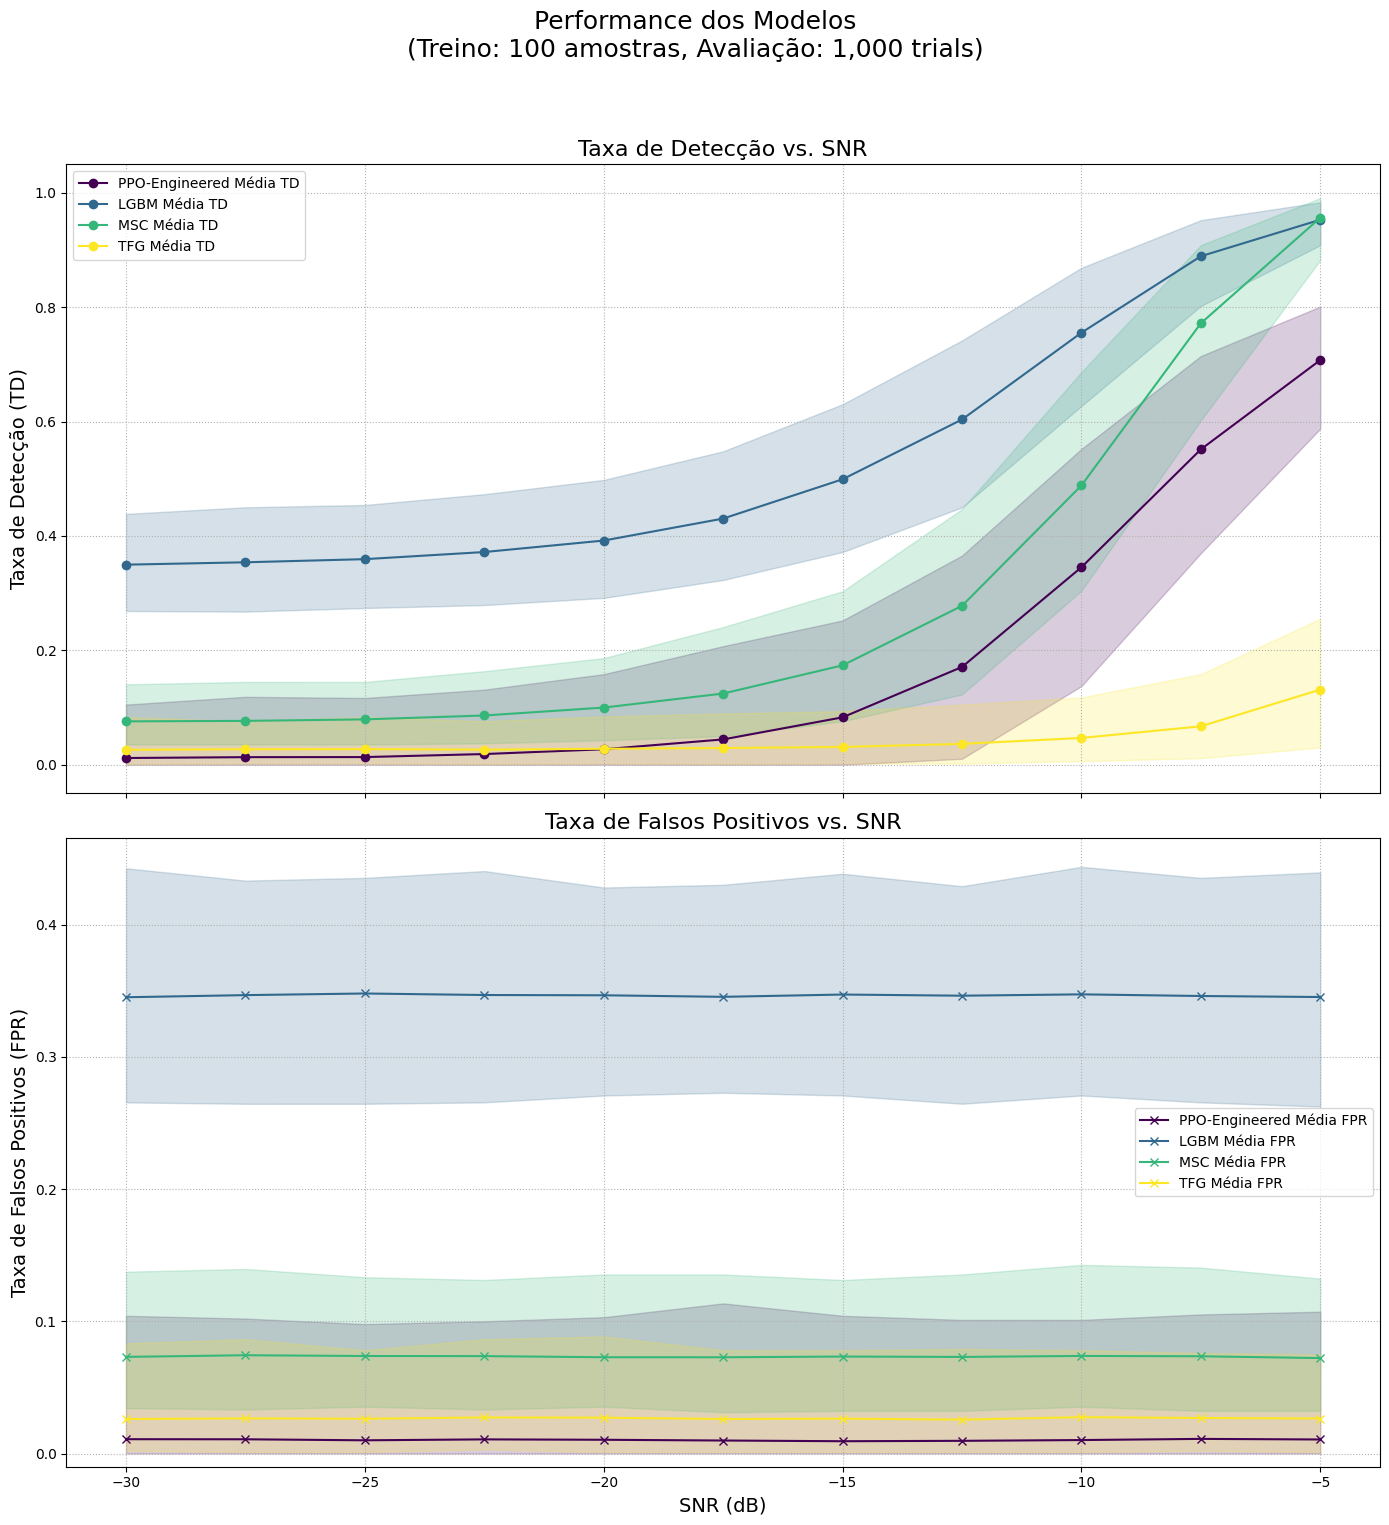

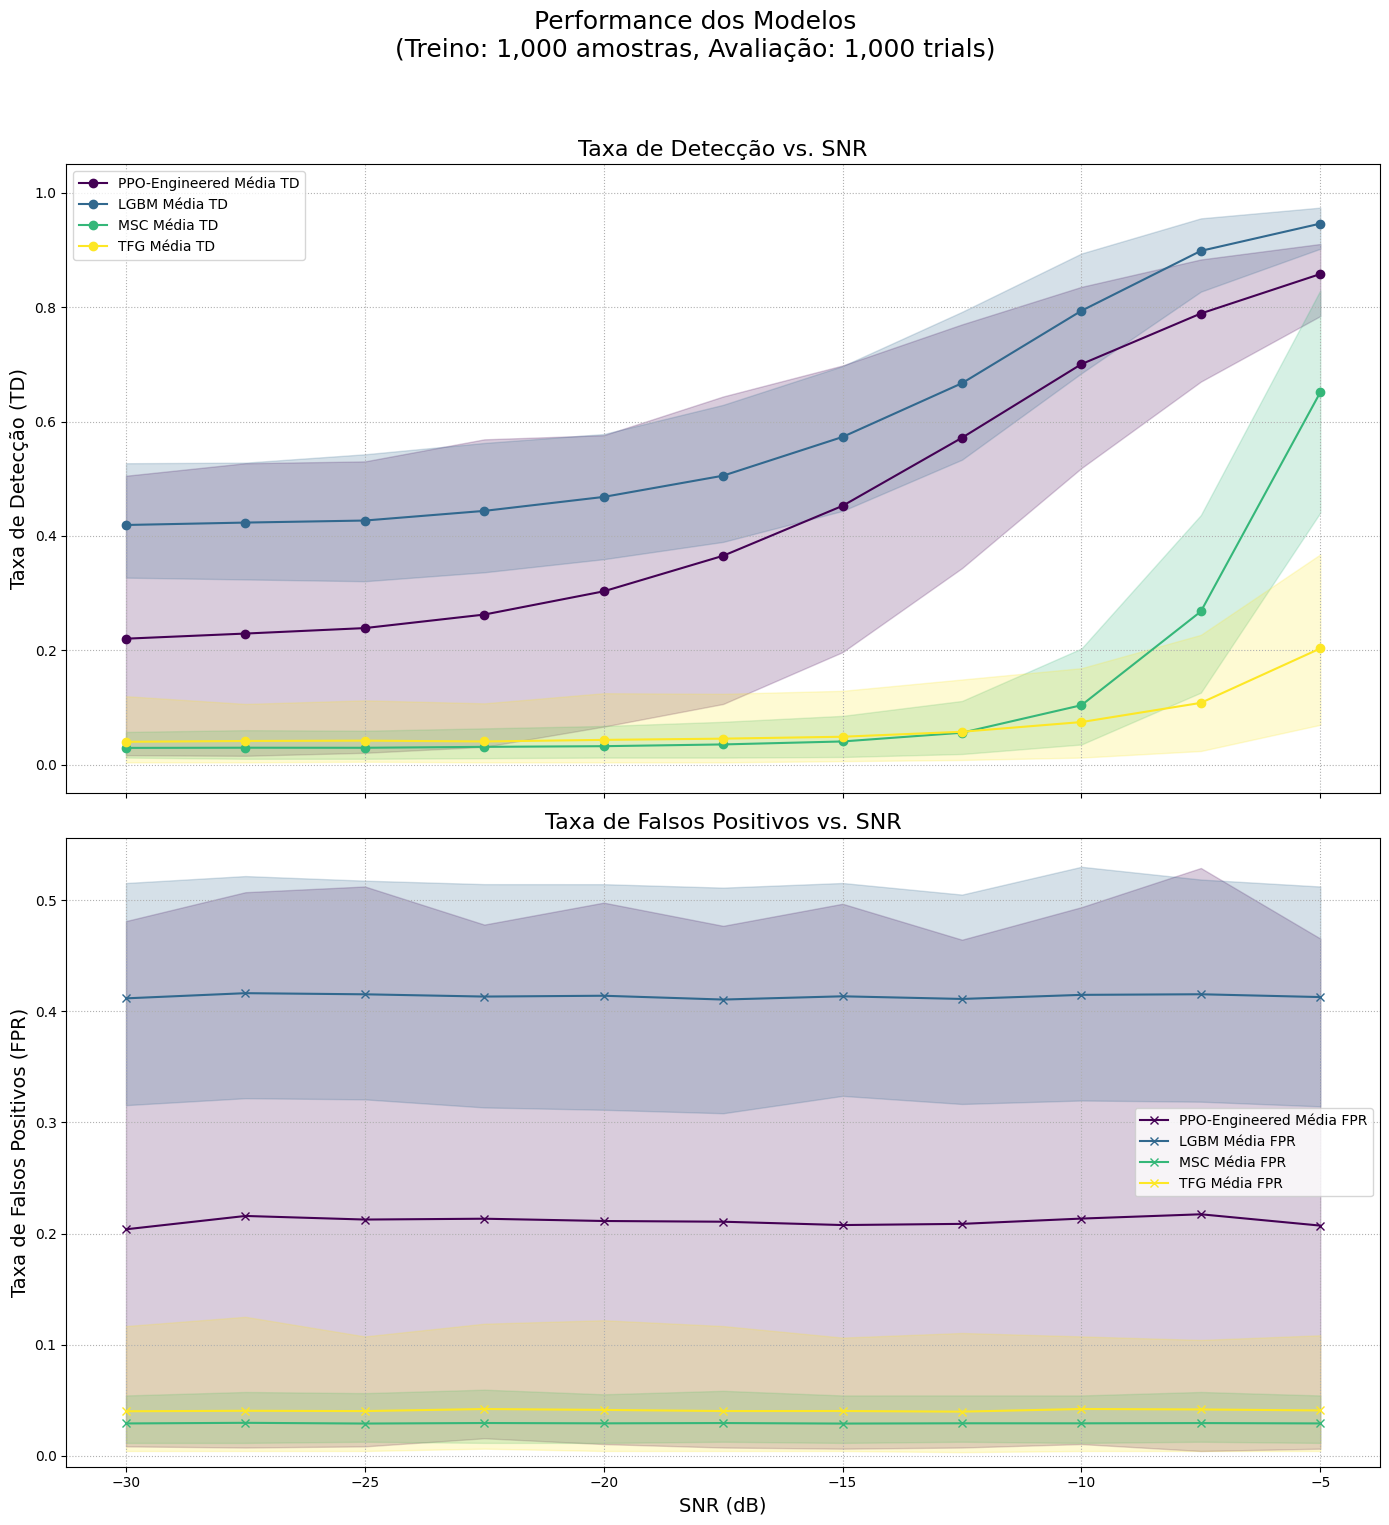

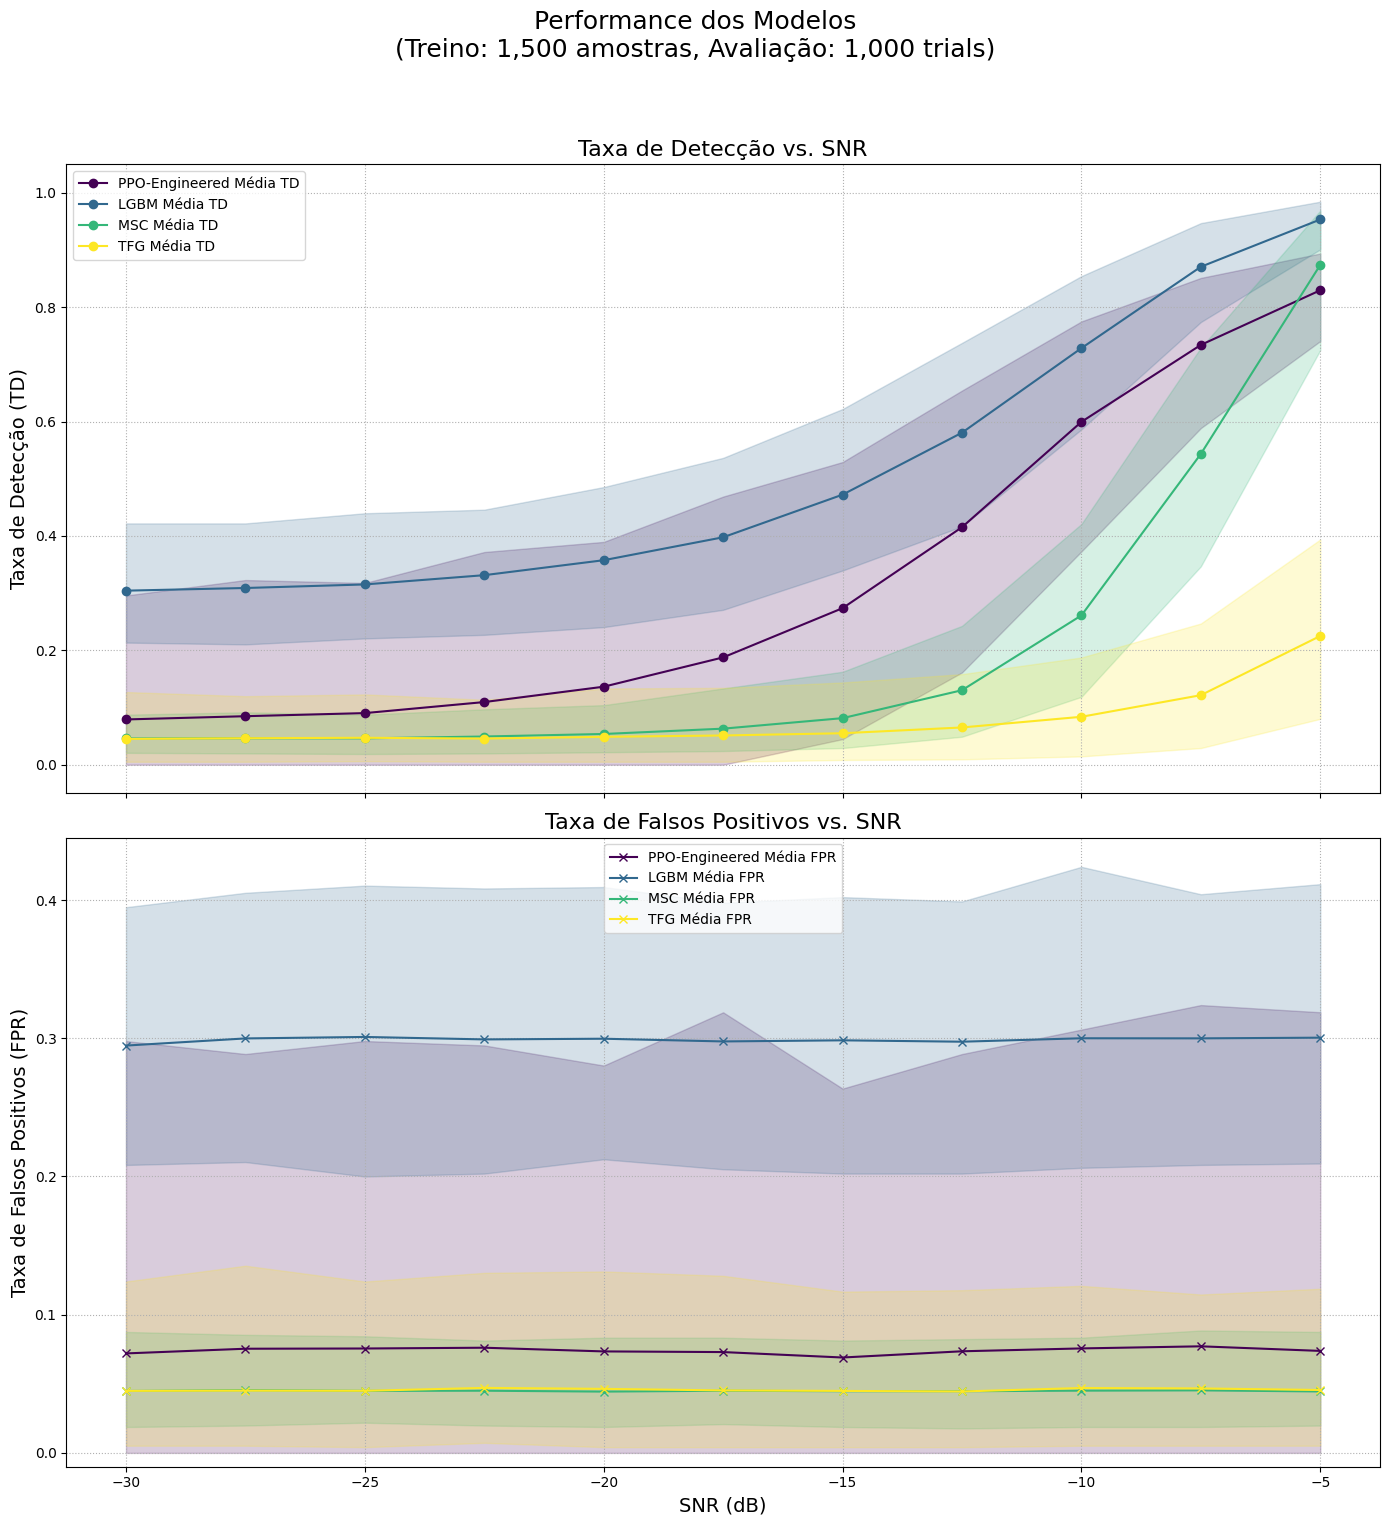

In [22]:
# CODE A (ADAPTED & OPTIMIZED)
"""
Full script for large-scale, iterative training and performance evaluation of detectors.

V5 - VECTORIZED FEATURE ENGINEERING
This version replaces the slow, iterative feature generation function with a
fully vectorized NumPy and pandas implementation for a massive performance boost.
The core logic remains the same, but the execution speed is orders of magnitude faster.
"""

# %% 1. Imports and Configuration
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from tqdm import tqdm
import math

# Ignore specific warnings to keep output clean
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning, message="Starting from version 2.2.1")

# ##############################################################################
# SECTION 1: USER-DEFINED PARAMETERS & CONFIGURATION
# ##############################################################################

# --- Experiment Control Parameters ---
TRAINING_SAMPLE_STOPS = [100, 1000, 1500]
EVAL_TRIAL_STOPS = [1000]

# --- Model Training Parameters ---
MODELS_TO_TRAIN_AND_EVAL = ['PPO-Engineered', 'LGBM', 'MSC', 'TFG']
RL_TRAINING_EPOCHS = 10
LGBM_N_ESTIMATORS = 100
NEGATIVE_REWARD = -5.0

# --- Data and Path Configuration ---
HDF5_TRAIN_FILEPATH = '../data/train_v4.hdf5'
HDF5_EVAL_FILEPATH = '../data/train_v4.hdf5'

# --- Signal and Feature Configuration ---
NUM_SIGNAL_FREQS = 8
ALL_SNRS = [-30.0, -27.5, -25.0, -22.5, -20.0, -17.5, -15.0, -12.5, -10.0, -7.5, -5.0]
RAW_FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
MAX_EVAL_TRIALS_PER_SNR = max(EVAL_TRIAL_STOPS)

# ##############################################################################
# FEATURE ENGINEERING CONFIGURATION (from Code B)
# This section defines how features are constructed for the PPO model.
# ##############################################################################
FEATURE_CONFIG = [
    # --- Simple Features (current value) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Moving Average Features ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),

    # --- Cumulative Sum Features ---
    ('MSC', 'cumsum', {}),
    ('CSM', 'cumsum', {}),

    # --- Time-based Feature ---
    ('timestamp', 'simple', {})
]
print(f"PPO model will use {len(FEATURE_CONFIG)} engineered features.")
# ##############################################################################

print(f"Training stops (samples): {TRAINING_SAMPLE_STOPS}")
print(f"Evaluation stops (trials/SNR): {EVAL_TRIAL_STOPS}")
print(f"Models to evaluate: {MODELS_TO_TRAIN_AND_EVAL}")


# ##############################################################################
# SECTION 2: DATA LOADING AND PREPARATION FUNCTIONS
# ##############################################################################

def my_norm(val, min_val=0, max_val=3):
    """Normalizes a value."""
    return (val - min_val) / (max_val - min_val) if max_val != min_val else 0.0

# OPTIMIZED: Fully vectorized feature generation function for massive speedup.
def generate_features_from_config_vectorized(data_4d, feature_names, config):
    """
    Generates engineered features using vectorized NumPy operations for high performance.
    Shape: (trials, windows, freqs, features) -> (trials, windows, freqs, engineered_features)
    """
    num_trials, num_windows, num_freqs, _ = data_4d.shape
    feature_indices = {name: i for i, name in enumerate(feature_names)}
    
    engineered_features_list = []

    for feature, transform, params in config:
        if feature == 'timestamp':
            ts = (np.arange(1, num_windows + 1) / num_windows).astype(np.float32)
            engineered_feature = np.tile(ts.reshape(1, -1, 1, 1), (num_trials, 1, num_freqs, 1))
            engineered_features_list.append(engineered_feature)
            continue
            
        feature_idx = feature_indices[feature]
        data_slice = data_4d[:, :, :, feature_idx]

        if transform == 'simple':
            engineered_feature = data_slice
            
        elif transform == 'cumsum':
            engineered_feature = np.cumsum(data_slice, axis=1)

        elif transform == 'cummean':
            cumulative_sum = np.cumsum(data_slice, axis=1)
            divisors = np.arange(1, num_windows + 1).reshape(1, -1, 1)
            engineered_feature = cumulative_sum / divisors

        elif transform == 'moving_mean':
            window_size = params.get('window_size', 10)
            # Reshape data to 2D for efficient processing with pandas
            reshaped_data = data_slice.transpose(0, 2, 1).reshape(-1, num_windows)
            # Apply rolling mean
            df = pd.DataFrame(reshaped_data.T)
            rolling_mean_df = df.rolling(window=window_size, min_periods=1).mean()
            # Reshape back to original 4D shape
            rolling_mean_T = rolling_mean_df.to_numpy().T
            engineered_feature = rolling_mean_T.reshape(num_trials, num_freqs, num_windows).transpose(0, 2, 1)

        else:
            raise ValueError(f"Unknown transformation: {transform}")
        
        engineered_features_list.append(my_norm(engineered_feature[..., np.newaxis]))

    return np.concatenate(engineered_features_list, axis=-1, dtype=np.float32)

def load_training_data_for_stage(filepath, snr_levels, total_samples_needed, num_signal_freqs):
    """
    Loads and prepares a specific number of training samples from 4D HDF5 data.
    Generates raw features for standard models and engineered features for PPO.
    """
    X_all_snrs_4d = []
    
    with h5py.File(filepath, 'r') as f:
        first_key = f"snr_{snr_levels[0]:.1f}"
        if first_key not in f:
                raise ValueError(f"Initial SNR key {first_key} not found in HDF5 file.")
        _, windows_per_trial, freqs_per_trial, _ = f[first_key]['metrics'].shape
        samples_per_trial = windows_per_trial * freqs_per_trial

    samples_per_snr = math.ceil(total_samples_needed / len(snr_levels))
    trials_per_snr = math.ceil(samples_per_snr / samples_per_trial)
    
    print(f"Loading up to {trials_per_snr} trials per SNR to gather enough samples.")
    
    with h5py.File(filepath, 'r') as f:
        for snr in snr_levels:
            key = f"snr_{snr:.1f}"
            if key in f:
                metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]
                X_all_snrs_4d.append(metrics_data_4d)
            else:
                print(f"Warning: Training SNR {snr} not found in {filepath}")

    if not X_all_snrs_4d:
        return None

    X_full_4d = np.vstack(X_all_snrs_4d)
    
    num_trials, num_windows, num_freqs, num_raw_features = X_full_4d.shape

    freq_labels = np.zeros(num_freqs)
    freq_labels[:num_signal_freqs] = 1
    y_labels_4d = np.tile(freq_labels, (num_trials, num_windows, 1))

    X_flat = X_full_4d.reshape(-1, num_raw_features)
    y_flat = y_labels_4d.flatten()

    p = np.random.permutation(len(X_flat))
    X_flat_shuffled = X_flat[p]
    y_flat_shuffled = y_flat[p]
    
    samples_to_take = min(total_samples_needed, len(X_flat_shuffled))
    X_train_flat = X_flat_shuffled[:samples_to_take]
    y_train_flat = y_flat_shuffled[:samples_to_take]
    
    print("Calculating engineered features for PPO model...")
    # UPDATED to call the fast vectorized function
    X_engineered_4d = generate_features_from_config_vectorized(X_full_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
    _, _, _, num_engineered_features = X_engineered_4d.shape
    X_engineered_flat = X_engineered_4d.reshape(-1, num_engineered_features)
    
    X_train_engineered = X_engineered_flat[p][:samples_to_take]

    return {
        'flat': (X_train_flat, y_train_flat),
        'engineered': (X_train_engineered, y_train_flat)
    }

def load_evaluation_data_for_snr(filepath, snr, trials_per_snr, num_signal_freqs):
    try:
        with h5py.File(filepath, 'r') as f:
            key = f"snr_{snr:.1f}"
            if key not in f:
                return np.array([]), np.array([])
            
            metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]

        signal_data_4d = metrics_data_4d[:, :, :num_signal_freqs, :]
        noise_data_4d = metrics_data_4d[:, :, num_signal_freqs:, :]
        
        return signal_data_4d, noise_data_4d
    except Exception as e:
        print(f"Error loading evaluation data for SNR {snr}: {e}")
        return np.array([]), np.array([])


# ##############################################################################
# SECTION 3: MODELS, ENVIRONMENT, AND HELPER FUNCTIONS (Unchanged)
# ##############################################################################

class SignalDetectionEnv(gym.Env):
    def __init__(self, features, labels, negative_reward=-1.0):
        super().__init__()
        self.features, self.labels = features, labels
        self.negative_reward = negative_reward
        self.current_step = 0
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)
    def step(self, action):
        predicted_label = 1 if action[0] > 0 else 0
        reward = 1.0 if predicted_label == self.labels[self.current_step] else self.negative_reward
        self.current_step += 1
        terminated = self.current_step >= len(self.features)
        next_obs = self.features[self.current_step] if not terminated else np.zeros(self.observation_space.shape)
        return next_obs, reward, terminated, False, {}
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return self.features[0], {}

class ORDTester:
    def __init__(self, desired_alpha=0.05, feature_names=RAW_FEATURE_NAMES):
        self.desired_alpha = desired_alpha
        self.feature_names = feature_names
        self.thresholds = {}
    def train(self, noise_features):
        for i, key in enumerate(self.feature_names):
            if noise_features.shape[0] > 0:
                self.thresholds[key] = np.percentile(noise_features[:, i], (1 - self.desired_alpha) * 100)
    def predict(self, features):
        decisions = {}
        for i, name in enumerate(self.feature_names):
            if name in self.thresholds:
                decisions[name] = (features[:, i] > self.thresholds[name]).astype(int)
            else:
                decisions[name] = np.zeros(features.shape[0], dtype=int)
        return decisions

def predict_lgbm(model, features_flat): return model.predict(features_flat)

def predict_ppo(model, features_flat):
    preds, _ = model.predict(features_flat, deterministic=True)
    preds[np.isnan(preds)] = 0
    return (preds > 0).astype(int)

def predict_statistical(model, features_flat, detector_name):
    decisions = model.predict(features_flat)
    return decisions.get(detector_name, np.zeros(features_flat.shape[0], dtype=int))

def calculate_statistics(predictions_per_trial):
    per_trial_metric = np.mean(predictions_per_trial, axis=1)
    return {
        'mean': np.mean(per_trial_metric),
        'variance': np.var(per_trial_metric),
        'p1': np.percentile(per_trial_metric, 1),
        'p99': np.percentile(per_trial_metric, 99)
    }

# ##############################################################################
# SECTION 4: MAIN EXPERIMENT AND ANALYSIS LOOP
# ##############################################################################
def run_full_experiment():
    """Main function to run the entire training and evaluation pipeline."""
    all_results_over_time = []
    policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))

    for training_size in tqdm(TRAINING_SAMPLE_STOPS, desc="Total Experiment Progress"):
        print(f"\n{'='*80}\nSTARTING STAGE: {training_size:,} samples\n{'='*80}")
        
        print(f"Loading {training_size:,} samples for training...")
        current_train_datasets = load_training_data_for_stage(
            HDF5_TRAIN_FILEPATH, ALL_SNRS, training_size, NUM_SIGNAL_FREQS
        )
        
        if current_train_datasets is None:
            print(f"Could not load data for training size {training_size}. Skipping stage.")
            continue
            
        print("Data loaded. Starting model training...")
        X_train_flat_slice, y_train_flat_slice = current_train_datasets['flat']
        X_train_engineered_slice, y_train_engineered_slice = current_train_datasets['engineered']

        trained_models_step = {}
        
        # --- Model Training Phase ---
        if 'LGBM' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training LGBM...")
            model_lgbm = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
            model_lgbm.fit(X_train_flat_slice, y_train_flat_slice)
            trained_models_step['LGBM'] = model_lgbm

        if 'PPO-Engineered' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training PPO-Engineered...")
            env = SignalDetectionEnv(X_train_engineered_slice, y_train_engineered_slice, NEGATIVE_REWARD)
            total_timesteps = len(X_train_engineered_slice) * RL_TRAINING_EPOCHS
            model_ppo = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, n_steps=min(2048, len(X_train_engineered_slice)), verbose=0)
            model_ppo.learn(total_timesteps=total_timesteps)
            trained_models_step['PPO-Engineered'] = model_ppo

        if 'MSC' in MODELS_TO_TRAIN_AND_EVAL or 'TFG' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training Statistical Detectors (ORD)...")
            ord_tester = ORDTester(feature_names=RAW_FEATURE_NAMES)
            ord_tester.train(X_train_flat_slice[y_train_flat_slice == 0])
            trained_models_step['MSC'] = ord_tester
            trained_models_step['TFG'] = ord_tester
            
        print(f"\n--- Starting Evaluation for models trained with {training_size:,} samples ---")
        
        # --- Evaluation Phase ---
        for eval_trials in tqdm(EVAL_TRIAL_STOPS, desc="Evaluation Stages", leave=False):
            for snr in tqdm(ALL_SNRS, desc=f"Evaluating SNRs (using {eval_trials} trials)", leave=False):
                signal_data_4d, noise_data_4d = load_evaluation_data_for_snr(
                    HDF5_EVAL_FILEPATH, snr, eval_trials, NUM_SIGNAL_FREQS
                )
                
                if signal_data_4d.size == 0 or noise_data_4d.size == 0: continue
                
                num_signal_trials, _, _, n_raw_features = signal_data_4d.shape
                num_noise_trials, _, _, _ = noise_data_4d.shape

                for model_name, model in trained_models_step.items():
                    if model_name == 'PPO-Engineered':
                        # UPDATED to call the fast vectorized function
                        engineered_signal_4d = generate_features_from_config_vectorized(signal_data_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                        engineered_noise_4d = generate_features_from_config_vectorized(noise_data_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                        
                        _, _, _, n_engineered_features = engineered_signal_4d.shape
                        
                        features_pd = engineered_signal_4d.reshape(-1, n_engineered_features)
                        features_fpr = engineered_noise_4d.reshape(-1, n_engineered_features)
                        
                        preds_pd = predict_ppo(model, features_pd)
                        preds_fpr = predict_ppo(model, features_fpr)
                    else:
                        features_pd = signal_data_4d.reshape(-1, n_raw_features)
                        features_fpr = noise_data_4d.reshape(-1, n_raw_features)
                        
                        if model_name == 'LGBM':
                            preds_pd = predict_lgbm(model, features_pd)
                            preds_fpr = predict_lgbm(model, features_fpr)
                        elif model_name in ['MSC', 'TFG']:
                            preds_pd = predict_statistical(model, features_pd, model_name)
                            preds_fpr = predict_statistical(model, features_fpr, model_name)
                    
                    td_stats = calculate_statistics(preds_pd.reshape(num_signal_trials, -1))
                    fpr_stats = calculate_statistics(preds_fpr.reshape(num_noise_trials, -1))

                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'TD', 'SNR': snr, 'Média': td_stats['mean'], 'Variância': td_stats['variance'], 'P1': td_stats['p1'], 'P99': td_stats['p99']})
                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'FPR', 'SNR': snr, 'Média': fpr_stats['mean'], 'Variância': fpr_stats['variance'], 'P1': fpr_stats['p1'], 'P99': fpr_stats['p99']})
    
    print("\n\n--- EXPERIMENT COMPLETED ---")
    return pd.DataFrame(all_results_over_time)

# ##############################################################################
# SECTION 5: FINAL PLOTTING AND VISUALIZATION (Unchanged)
# ##############################################################################

def plot_performance_curves_with_ci(df, training_stop, eval_stop):
    """Plots TD and FPR vs. SNR curves with 98% confidence intervals."""
    df_plot = df[(df['Amostras Treino'] == training_stop) & (df['Trials Avaliação'] == eval_stop)]
    
    if df_plot.empty:
        print(f"\nWarning: No evaluation data found for {training_stop} training samples and {eval_stop} eval trials.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), sharex=True)
    title = (f'Performance dos Modelos\n'
             f'(Treino: {training_stop:,.0f} amostras, Avaliação: {eval_stop:,.0f} trials)')
    fig.suptitle(title, fontsize=18)

    colors = plt.cm.viridis(np.linspace(0, 1, len(MODELS_TO_TRAIN_AND_EVAL)))
    model_colors = {model: color for model, color in zip(MODELS_TO_TRAIN_AND_EVAL, colors)}

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'TD')].sort_values('SNR')
        if not model_data.empty:
            ax1.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média TD', color=model_colors[model], marker='o')
            ax1.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax1.set_ylabel('Taxa de Detecção (TD)', fontsize=14)
    ax1.set_title('Taxa de Detecção vs. SNR', fontsize=16)
    ax1.grid(True, which='both', linestyle=':')
    ax1.legend()
    ax1.set_ylim(-0.05, 1.05)

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'FPR')].sort_values('SNR')
        if not model_data.empty:
            ax2.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média FPR', color=model_colors[model], marker='x')
            ax2.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax2.set_xlabel('SNR (dB)', fontsize=14)
    ax2.set_ylabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    ax2.set_title('Taxa de Falsos Positivos vs. SNR', fontsize=16)
    ax2.grid(True, which='both', linestyle=':')
    ax2.legend()
    ax2.set_ylim(bottom=-0.01)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ##############################################################################
# SECTION 6: SCRIPT EXECUTION
# ##############################################################################

if __name__ == '__main__':
    final_df = run_full_experiment()

    if not final_df.empty:
        print("\n\n--- Final Analysis & Visualization ---")
        
        snr_for_analysis = -10.0
        print(f"\n--- Evolution of Mean TD (at SNR={snr_for_analysis}dB) vs. Training Samples ---")
        pivot_td = final_df[
            (final_df['Métrica'] == 'TD') & 
            (final_df['SNR'] == snr_for_analysis)
        ].pivot_table(
            index='Amostras Treino', columns='Modelo', values='Média'
        )
        print(pivot_td.to_string())

        print("\n\n--- Generating Performance Plots for Each Training Stage ---")
        for train_stop in TRAINING_SAMPLE_STOPS:
            plot_performance_curves_with_ci(final_df, train_stop, max(EVAL_TRIAL_STOPS))
    else:
        print("\nExperiment finished, but no results were generated to plot.")